
# **Step 0: Mount Drive and Paths**

In [ ]:
# === 0. Mount Google Drive and define paths ===
#from google.colab import drive
#drive.mount('/content/drive')

from google.colab import drive
drive.mount('/content/drive')

import os, zipfile

# CHANGE THESE IF NEEDED
SHARED_ROOT = "/content/drive/Shared drives/ECS171 Group project 9"
ZIP_PATH    = os.path.join(SHARED_ROOT, "PreProcessed_data", "all_visits_packages.zip")
LABEL_XLSX  = os.path.join(SHARED_ROOT, "PreProcessed_data", "filtered_tab_data.xlsx")

ROOT         = "/content/oasis_data"
PATIENTS_DIR = os.path.join(ROOT, "patients")

os.makedirs(ROOT, exist_ok=True)
os.makedirs(PATIENTS_DIR, exist_ok=True)

print("ZIP_PATH   :", ZIP_PATH)
print("LABEL_XLSX :", LABEL_XLSX)
print("ROOT       :", ROOT)
print("PATIENTS   :", PATIENTS_DIR)

# Extract zip once
if not any(os.scandir(PATIENTS_DIR)):
    print("Extracting all_visits_packages.zip ...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        zf.extractall(PATIENTS_DIR)
else:
    print("Patients already extracted at", PATIENTS_DIR)

# Quick peek
import glob
patients = sorted([d for d in os.listdir(PATIENTS_DIR) if os.path.isdir(os.path.join(PATIENTS_DIR, d))])
print(f"Found {len(patients)} patient folders (visits), e.g.:", patients[:5])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ZIP_PATH   : /content/drive/Shared drives/ECS171 Group project 9/PreProcessed_data/all_visits_packages.zip
LABEL_XLSX : /content/drive/Shared drives/ECS171 Group project 9/PreProcessed_data/filtered_tab_data.xlsx
ROOT       : /content/oasis_data
PATIENTS   : /content/oasis_data/patients
Patients already extracted at /content/oasis_data/patients
Found 402 patient folders (visits), e.g.: ['OAS1_0001_MR1', 'OAS1_0002_MR1', 'OAS1_0003_MR1', 'OAS1_0004_MR1', 'OAS1_0005_MR1']


### Citations
**AI Assitance**

Used OpenAI's ChatGPT to implement loading in the data through zip paths and the google drive

# **Step 1: Imports & Device**

In [ ]:
# === 1. Core imports & device ===
import re
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
from torchvision import models

from sklearn.metrics import classification_report, confusion_matrix

# Random Seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## Explaination
Here we import torch sklearn.metrics, and set some random seed

# **Step 2: Load Labels (outlier_removed.xlsx → visit_id & class)**

Assumes columns: Patient ID, CDR.


In [ ]:
# **Step 2: Load Labels (outlier_removed.xlsx → visit_id & BINARY class)**

# === 2. Load labels from outlier_removed.xlsx ===
df_labels_raw = pd.read_excel(LABEL_XLSX) # <-- Excel Sheet full of Labels
df_labels_raw.columns = [c.strip() for c in df_labels_raw.columns]
assert "Patient ID" in df_labels_raw.columns and "CDR" in df_labels_raw.columns

df_labels = df_labels_raw.copy()

# visit_id should match folder names like OAS1_0001_MR1
df_labels["visit_id"] = df_labels["Patient ID"].astype(str).str.strip().str.upper()

# numeric CDR (C Dimentia Rate)
df_labels["cdr"] = pd.to_numeric(df_labels["CDR"], errors="coerce")

# keep rows with valid CDR
df_labels = df_labels[~df_labels["cdr"].isna()].reset_index(drop=True)

# === BINARY LABELS ===
# 0 = No Dementia (CDR == 0.0)
# 1 = Dementia    (CDR >= 0.5)
df_labels["y"] = (df_labels["cdr"] >= 0.5).astype(int)

CLASS_NAMES = ["No Dementia", "Dementia"]
df_labels["label_str"] = df_labels["y"].map({0: CLASS_NAMES[0], 1: CLASS_NAMES[1]})

print("Label distribution (all patients in label file):")
display(df_labels["label_str"].value_counts())


Label distribution (all patients in label file):


,count
label_str,
No Dementia,132
Dementia,83


# **Step 3: Build a Slice-Level DataFrame from Patient Folders**

Each patient folder:
OAS1_0001_MR1/ → *.png, manifest_OAS1_0001_MR1.csv, tabular_OAS1_0001_MR1.csv

We’ll use:

PNG paths → images

tabular_*.csv → volumetric features (csf_ml, gm_ml, etc.)

labels from df_labels → y

In [ ]:
# === 3. Scan patient folders and build slice-level dataframe ===
import glob
import os

all_rows = []
tab_feature_cols = None  # will detect from first CSV

for folder in tqdm(sorted(os.listdir(PATIENTS_DIR)), desc="Processing patient folders"):
    folder_path = os.path.join(PATIENTS_DIR, folder)
    if not os.path.isdir(folder_path):
        continue

    visit_id = folder.upper().strip()  # e.g., OAS1_0001_MR1

    # Lookup label for this visit
    row_label = df_labels[df_labels["visit_id"] == visit_id]
    if row_label.empty:
        # skip patients not in outlier_removed.xlsx
        continue

    label_str = row_label["label_str"].iloc[0]
    y = row_label["y"].iloc[0]
    cdr = row_label["cdr"].iloc[0]

    # Load tabular features if present
    tab_csvs = glob.glob(os.path.join(folder_path, "tabular_*.csv"))
    tab_feats = {}
    if tab_csvs: # OpenAI (2025)
        df_tab = pd.read_csv(tab_csvs[0])
        # First row assumed to contain per-visit volumes
        for col in df_tab.columns:
            if col.lower() in ["visit_id", "subject_root"]:
                continue
            tab_feats[col] = df_tab[col].iloc[0]
        if tab_feature_cols is None:
            tab_feature_cols = sorted(tab_feats.keys())
    else:
        # no tabular features for this visit
        if tab_feature_cols is None:
            tab_feature_cols = []

    # Collect slice PNGs
    pngs = sorted(glob.glob(os.path.join(folder_path, "*.png")))
    for p in pngs:
        row = {
            "visit_id": visit_id,
            "png_path": p,
            "label_str": label_str,
            "y": y,
            "cdr": cdr,
        }
        for col in tab_feature_cols:
            row[col] = tab_feats.get(col, np.nan)
        all_rows.append(row)

df = pd.DataFrame(all_rows)
print(f"Collected {len(df)} slices from {df['visit_id'].nunique()} patients.")
print("Slice label distribution:")
display(df["label_str"].value_counts())

if tab_feature_cols:
    print("Tabular features used:", tab_feature_cols)
else:
    print("No tabular features found; fusion will be image-only unless you add them.")


Processing patient folders: 100%|██████████| 402/402 [00:00<00:00, 781.91it/s]


Collected 2460 slices from 205 patients.
Slice label distribution:


,count
label_str,
No Dementia,1548
Dementia,912


Tabular features used: ['brain_ml', 'csf_ml', 'csf_ratio', 'gm_ml', 'gm_ratio', 'gm_wm_ratio', 'source_txt', 'wm_ml', 'wm_ratio']


### Citation
**AI Assitance**

Used OpenAI's ChatGPT to help implement loading in the features

# **Step 4: Train/Val/Test Split by Patient (85% / 15%)**

In [ ]:
# === 4. Train/val/test split by patient (visit_id) ===
from sklearn.model_selection import train_test_split

visits = df["visit_id"].unique()
visits_train, visits_test = train_test_split(
    visits, test_size=0.15, random_state=SEED, stratify=df.groupby("visit_id")["y"].first()
)

# Optionally split train into train/val
visits_train, visits_val = train_test_split(
    visits_train, test_size=0.1, random_state=SEED, stratify=df[df["visit_id"].isin(visits_train)].groupby("visit_id")["y"].first()
)

print(f"Train patients: {len(visits_train)}, Val: {len(visits_val)}, Test: {len(visits_test)}")

df_train = df[df["visit_id"].isin(visits_train)].reset_index(drop=True)
df_val   = df[df["visit_id"].isin(visits_val)].reset_index(drop=True)
df_test  = df[df["visit_id"].isin(visits_test)].reset_index(drop=True)

print("Slices per split:")
print("  Train:", len(df_train))
print("  Val  :", len(df_val))
print("  Test :", len(df_test))


Train patients: 156, Val: 18, Test: 31
Slices per split:
  Train: 1872
  Val  : 216
  Test : 372


# **Step 5: Transforms (MRI-Friendly)**

In [ ]:
# **Step 5: Transforms (MRI-Friendly, binary setup)**

# === 5. Data transforms (MRI-friendly) ===
IMG_SIZE = 224  # matches your PNG generation

transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),         # ensure consistent size
    transforms.RandomHorizontalFlip(p=0.5),          # left/right symmetry OK
    transforms.RandomRotation(degrees=10),           # small rotations
    transforms.RandomAffine(
        degrees=0,
        translate=(0.02, 0.02),                      # small shifts
        scale=(0.95, 1.05),                          # slight zoom
    ),
    transforms.ToTensor(),                           # [1, H, W] from "L" mode
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

transform_eval = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


# **Step 6: Custom Dataset with Early Fusion Inputs**

In [ ]:
# === 6. Custom Dataset: image + tabular features ===
class MRISliceDataset(Dataset):
    def __init__(self, df, transform=None, tabular_cols=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.tabular_cols = tabular_cols or []

        # Pre-extract tabular matrix for speed
        if self.tabular_cols:
            self.X_tab = self.df[self.tabular_cols].fillna(0.0).astype(np.float32).values
        else:
            self.X_tab = None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["png_path"]
        label = int(row["y"])

        # Load grayscale image
        img = Image.open(img_path).convert("L")  # "L" = 1-channel

        if self.transform:
            img = self.transform(img)  # tensor [1, H, W]
        else:
            img = transforms.ToTensor()(img)

        if self.X_tab is not None:
            x_tab = torch.from_numpy(self.X_tab[idx])
        else:
            x_tab = torch.zeros(0, dtype=torch.float32)

        return img, x_tab, label


### Citation
**AI Assitance**

Used OpenAI's ChatGPT to explain on making the MRISliceDataset, explaining on what tp do


# **Step 7: WeightedRandomSampler (Balance Classes)**

In [ ]:
# **Step 7: WeightedRandomSampler (Balance Classes) + class weights for loss**

from torch.utils.data import WeightedRandomSampler

train_labels = df_train["y"].values  # 0 = No Dementia, 1 = Dementia
num_classes = len(CLASS_NAMES)

class_counts = np.bincount(train_labels, minlength=num_classes)
class_counts[class_counts == 0] = 1  # avoid div-by-zero
inv_counts = 1.0 / class_counts

# For the sampler, we keep inverse-frequency weights
sample_weights = inv_counts[train_labels]
sampler = WeightedRandomSampler(
    weights=torch.from_numpy(sample_weights).double(),
    num_samples=len(sample_weights),
    replacement=True
)

print("Class counts in train:", dict(zip(range(num_classes), class_counts)))
print("Inverse-frequency sampler weights:", inv_counts)

# For the loss, we can emphasize Dementia a bit more (e.g., ×1.5)
ce_weights = inv_counts / inv_counts.sum() # normalize if you like
ce_weights[1] = ce_weights[1] # * 1.5        # boost Dementia
ce_weights = ce_weights / ce_weights.sum() # renormalize

print("Cross-entropy class weights (No Dementia, Dementia):", ce_weights)

# Store as torch tensor to use in Step 10
CE_WEIGHTS_TENSOR = torch.tensor(ce_weights, dtype=torch.float32).to(device)


Class counts in train: {0: np.int64(1152), 1: np.int64(720)}
Inverse-frequency sampler weights: [0.00086806 0.00138889]
Cross-entropy class weights (No Dementia, Dementia): [0.38461538 0.61538462]


# **Step 8: DataLoaders**

In [ ]:
# **Step 8: DataLoaders**

# === 8. Build datasets and loaders (clean tabular columns automatically) ===

# Remove columns that cannot be numeric tabular features OR that leak labels
cols_to_exclude = [
    "png_path",
    "visit_id",
    "subject_root",
    "label",
    "label_str",
    "y",          # target
    "CDR",
    "cdr",        # target-like
]

possible_cols = [
    c for c in df_train.columns
    if c not in cols_to_exclude
]

# Select only numeric columns
TAB_COLS = [
    c for c in possible_cols
    if pd.api.types.is_numeric_dtype(df_train[c])
]

print("Tabular feature columns =", TAB_COLS)

# Build datasets
ds_train = MRISliceDataset(df_train, transform=transform_train, tabular_cols=TAB_COLS)
ds_val   = MRISliceDataset(df_val,   transform=transform_eval,   tabular_cols=TAB_COLS)
ds_test  = MRISliceDataset(df_test,  transform=transform_eval,   tabular_cols=TAB_COLS)

# Loaders
BATCH_SIZE = 32

train_loader = DataLoader(
    ds_train, batch_size=BATCH_SIZE, sampler=sampler,
    num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    ds_val, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)

test_loader = DataLoader(
    ds_test, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)

len(train_loader), len(val_loader), len(test_loader)


Tabular feature columns = ['brain_ml', 'csf_ml', 'csf_ratio', 'gm_ml', 'gm_ratio', 'gm_wm_ratio', 'wm_ml', 'wm_ratio']


(59, 7, 12)

# **Step 9: Early-Fusion Model: Pretrained ResNet50 + Tabular MLP**

In [ ]:
# **Step 9: Early-Fusion Model: Pretrained ResNet50 + Tabular MLP (Binary)**

class ResNet50TabularFusion(nn.Module):
    def __init__(self, num_tab_features, num_classes=2, freeze_backbone=True):
        super().__init__()
        base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Adjust first conv to 1-channel for grayscale MRI
        base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Backbone without final FC
        self.cnn = nn.Sequential(*list(base.children())[:-1])  # [B, 2048, 1, 1] <- Layer Applied
        self.cnn_out_dim = 2048

        # Optionally freeze backbone at first
        if freeze_backbone:
            for p in self.cnn.parameters():
                p.requires_grad = False

        self.use_tab = num_tab_features > 0
        if self.use_tab:
            self.tab_mlp = nn.Sequential(
                nn.Linear(num_tab_features, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Dropout(0.2),
            )
            tab_out_dim = 64
        else:
            tab_out_dim = 0

        fusion_in = self.cnn_out_dim + tab_out_dim

        self.head = nn.Sequential(
            nn.Linear(fusion_in, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

    def forward(self, x_img, x_tab=None):
        feats = self.cnn(x_img)                # [B, 2048, 1, 1]
        feats = feats.view(feats.size(0), -1)  # [B, 2048]

        if self.use_tab and x_tab is not None and x_tab.numel() > 0:
            tab = self.tab_mlp(x_tab)          # [B, 64]
            fused = torch.cat([feats, tab], dim=1)
        else:
            fused = feats

        logits = self.head(fused)
        return logits

    def unfreeze_last_block(self):
        """
        Unfreeze last ResNet block for fine-tuning stage (layer4).
        """
        for name, param in self.cnn.named_parameters():
            if "layer4" in name:
                param.requires_grad = True

num_tab_features = len(TAB_COLS)
num_classes = 2  # binary

model = ResNet50TabularFusion(num_tab_features=0, # CHANGING TAB FEATURES TO 0
                              num_classes=num_classes,
                              freeze_backbone=True).to(device)

print("Trainable params:",
      sum(p.numel() for p in model.parameters() if p.requires_grad))


Trainable params: 525570


### Citation
**AI Assistance**

Used OpenAI ChatGPT to help make the optional tabular

# **Step 10: Training Setup: Optimizer, Scheduler, TensorBoard**

In [ ]:
# **Step 10: Training Setup: Optimizer, Scheduler, TensorBoard (Stage 1)**

# Use class-weighted loss to emphasize Dementia
criterion = nn.CrossEntropyLoss(weight=CE_WEIGHTS_TENSOR)

# Learning rate =
# Stage 1: only train head + tabular branch (backbone frozen)
optimizer_stage1 = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-4,
)

# lr=1e-3

writer = SummaryWriter(log_dir="/content/runs/oasis_resnet_fusion_binary")

def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

def run_epoch(loader, model, optimizer=None, train=True, epoch=0, tag="stage"):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for imgs, x_tab, labels in loader:
        imgs = imgs.to(device)
        x_tab = x_tab.to(device)
        labels = labels.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            logits = model(imgs, x_tab)
            loss = criterion(logits, labels)
            if train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)

    avg_loss = total_loss / max(total_samples, 1)
    acc = total_correct / max(total_samples, 1)
    mode = "train" if train else "val"
    print(f"[{tag}][{mode}] epoch {epoch} | loss={avg_loss:.4f} | acc={acc:.4f}")
    return avg_loss, acc

#%load_ext tensorboard
#%tensorboard --logdir /content/runs


# **Step 11: Training Loop with Val Metrics**

In [ ]:
train_acc = []
train_losses = []
va_accs = []
va_losses = []

train_acc2 = []
train_losses2 = []
va_accs2 = []
va_losses2 = []


In [ ]:
# **Step 11: Two-Stage Training Loop (freeze → fine-tune)**

best_val_acc = 0.0
best_state = None

# --- Stage 1: train head + tabular branch only ---
EPOCHS_STAGE1 = 20
for epoch in range(1, EPOCHS_STAGE1 + 1):
    tr_loss, tr_acc = run_epoch(train_loader, model, optimizer_stage1,
                                train=True, epoch=epoch, tag="stage1")
    va_loss, va_acc = run_epoch(val_loader, model, optimizer=None,
                                train=False, epoch=epoch, tag="stage1")
    train_losses.append(tr_loss)
    train_acc.append(tr_acc)
    va_accs.append(va_acc)
    va_losses.append(va_loss)

    writer.add_scalars("stage1/loss", {"train": tr_loss, "val": va_loss}, epoch)
    writer.add_scalars("stage1/acc",  {"train": tr_acc,  "val": va_acc},  epoch)

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = model.state_dict().copy()

# Load best from stage 1 before fine-tuning
if best_state is not None:
    model.load_state_dict(best_state)
    print("Loaded best model from Stage 1 with val_acc =", best_val_acc)

# --- Stage 2: unfreeze last ResNet block and fine-tune ---
model.unfreeze_last_block()

optimizer_stage2 = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=1e-5,
)

EPOCHS_STAGE2 = 20
for epoch in range(1, EPOCHS_STAGE2 + 1):
    tr_loss, tr_acc = run_epoch(train_loader, model, optimizer_stage2,
                                train=True, epoch=epoch, tag="stage2")
    va_loss, va_acc = run_epoch(val_loader, model, optimizer=None,
                                train=False, epoch=epoch, tag="stage2")

    train_losses2.append(tr_loss)
    train_acc2.append(tr_acc)
    va_accs2.append(va_acc)
    va_losses2.append(va_loss)

    writer.add_scalars("stage2/loss", {"train": tr_loss, "val": va_loss}, epoch)
    writer.add_scalars("stage2/acc",  {"train": tr_acc,  "val": va_acc},  epoch)

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = model.state_dict().copy()

print(" --> Training complete. Best val_acc =", best_val_acc)
if best_state is not None:
    model.load_state_dict(best_state)
    print(" --> Loaded best model weights (after Stage 2)")


[stage1][train] epoch 1 | loss=0.6209 | acc=0.6619
[stage1][val] epoch 1 | loss=0.8641 | acc=0.4630
[stage1][train] epoch 2 | loss=0.5646 | acc=0.6848
[stage1][val] epoch 2 | loss=0.6530 | acc=0.6343
[stage1][train] epoch 3 | loss=0.5752 | acc=0.6763
[stage1][val] epoch 3 | loss=0.6433 | acc=0.6204
[stage1][train] epoch 4 | loss=0.5784 | acc=0.6629
[stage1][val] epoch 4 | loss=0.7663 | acc=0.5833
[stage1][train] epoch 5 | loss=0.5419 | acc=0.7083
[stage1][val] epoch 5 | loss=0.8257 | acc=0.5417
[stage1][train] epoch 6 | loss=0.5581 | acc=0.6971
[stage1][val] epoch 6 | loss=0.6973 | acc=0.5556
[stage1][train] epoch 7 | loss=0.5504 | acc=0.6912
[stage1][val] epoch 7 | loss=0.7293 | acc=0.5370
[stage1][train] epoch 8 | loss=0.5400 | acc=0.7030
[stage1][val] epoch 8 | loss=0.6323 | acc=0.6667
[stage1][train] epoch 9 | loss=0.5572 | acc=0.6859
[stage1][val] epoch 9 | loss=0.7828 | acc=0.5278
[stage1][train] epoch 10 | loss=0.5268 | acc=0.7179
[stage1][val] epoch 10 | loss=0.7135 | acc=0.574

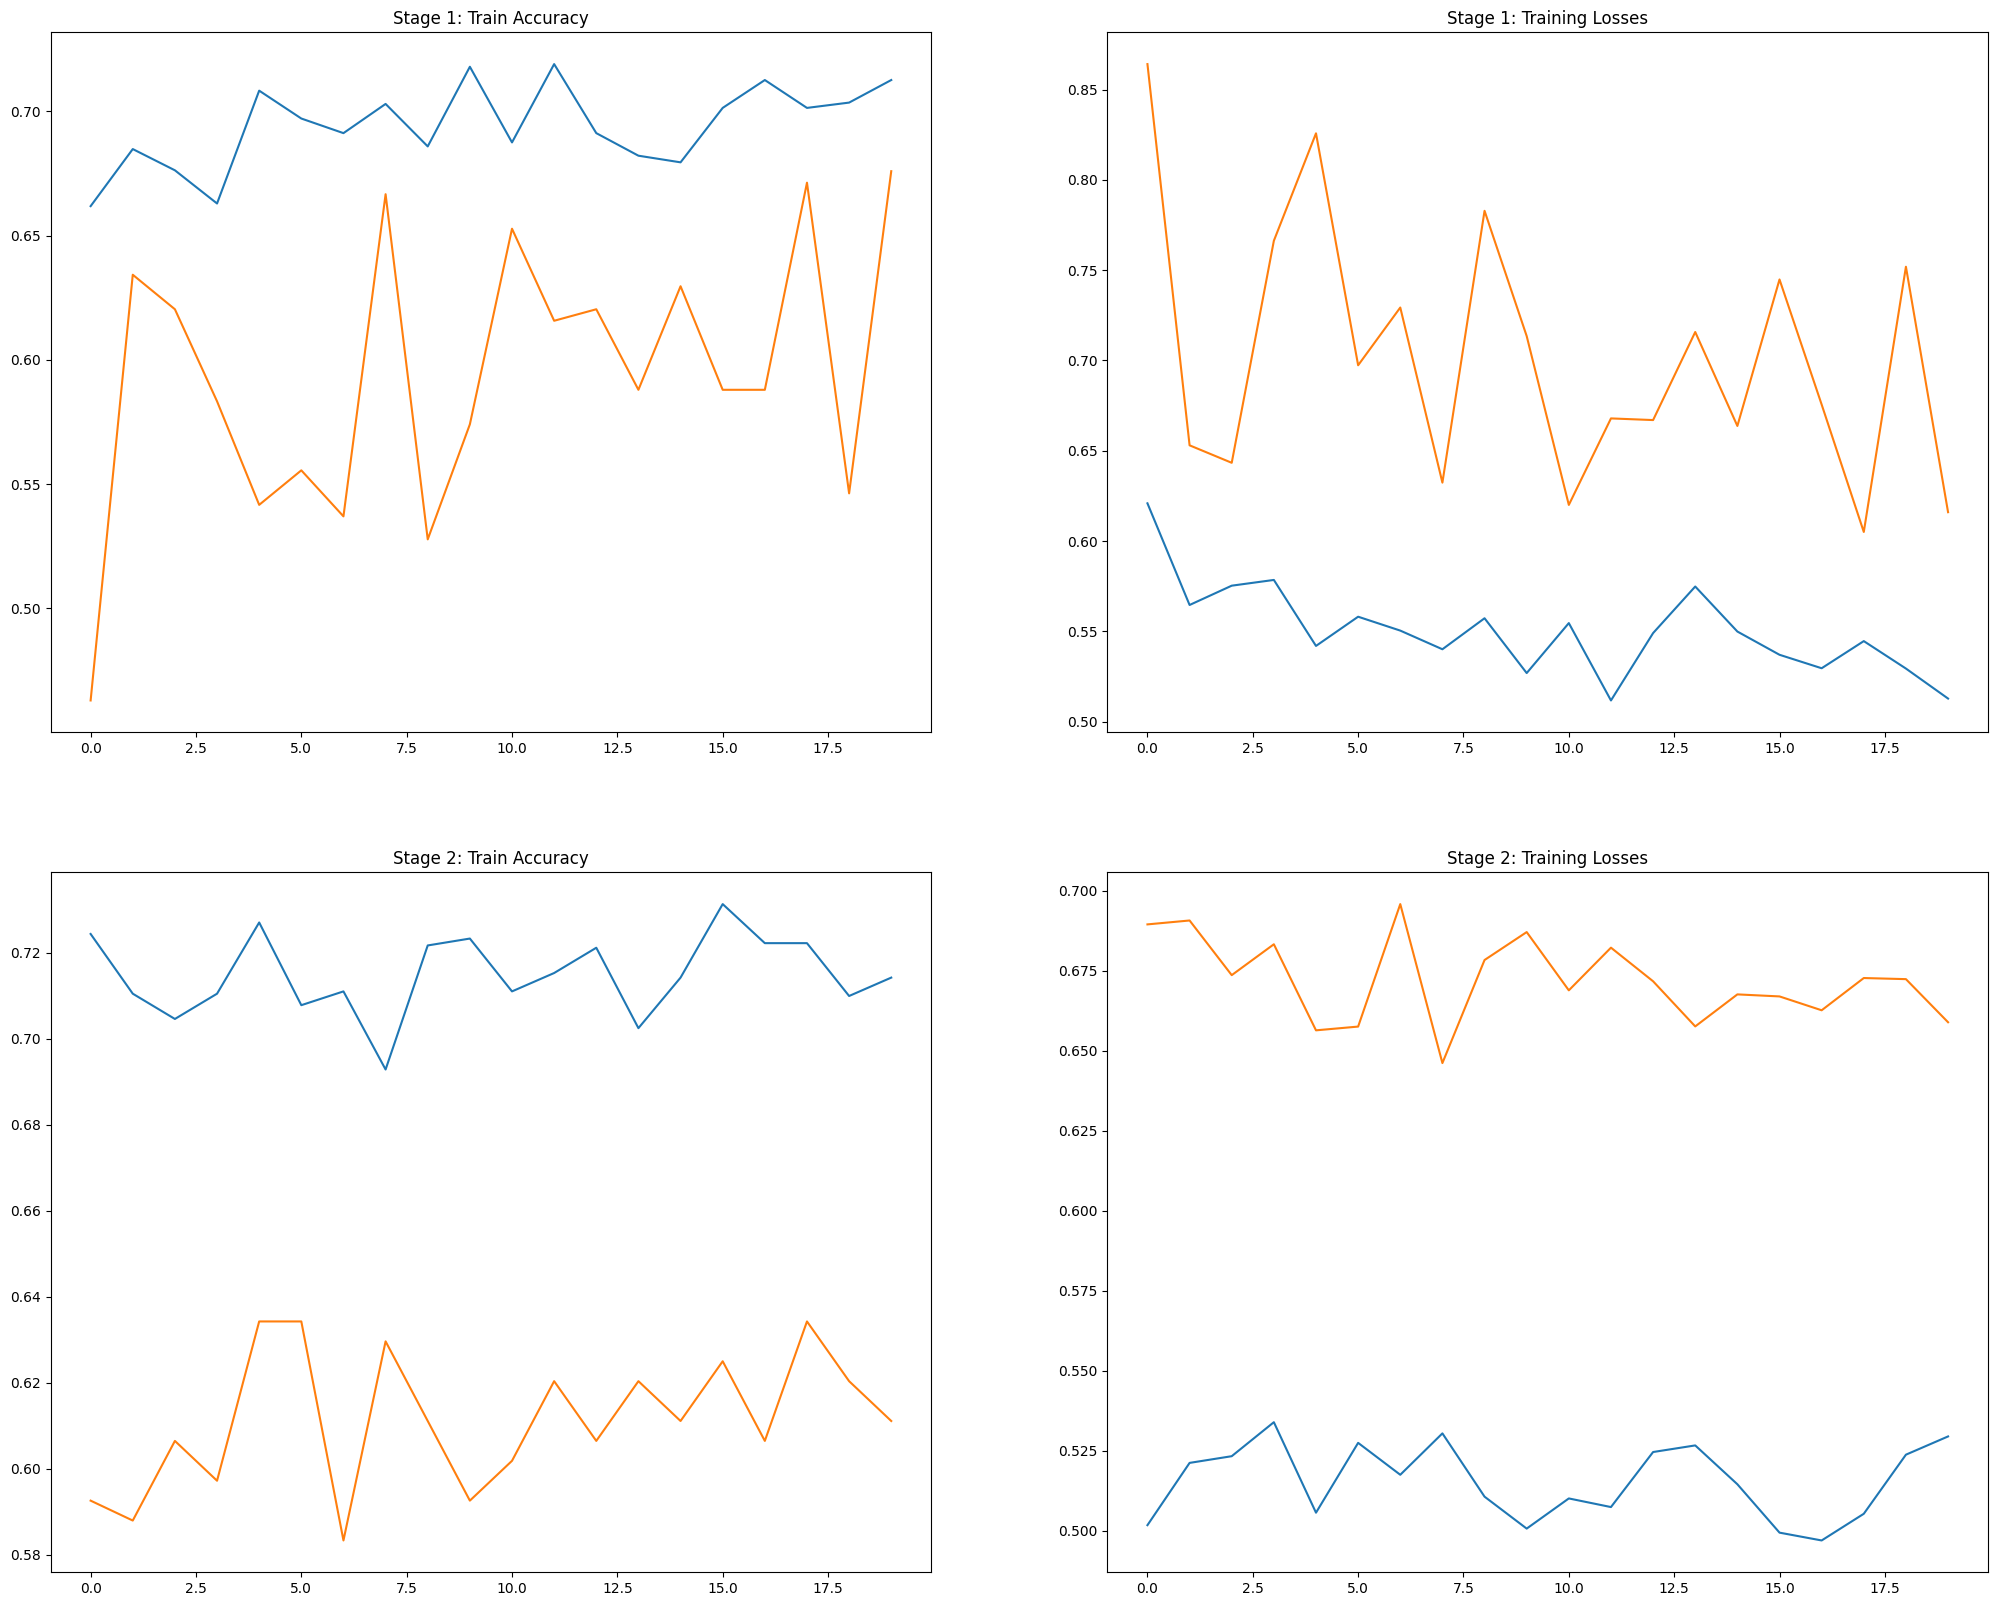

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Stage 1: Train Accuracy')
axs[0,1].set_title('Stage 1: Training Losses')
axs[1,0].set_title('Stage 2: Train Accuracy')
axs[1,1].set_title('Stage 2: Training Losses')

axs[0,0].plot(train_acc)
axs[0,1].plot(train_losses)
axs[0,0].plot(va_accs)
axs[0,1].plot(va_losses)

axs[1,0].plot(train_acc2)
axs[1,1].plot(train_losses2)
axs[1,0].plot(va_accs2)
axs[1,1].plot(va_losses2)

# **Step 12: Test Evaluation + Confusion Matrix**


Classes present in TEST set: [0 1] → ['No Dementia', 'Dementia']

Slice-level classification report:
              precision    recall  f1-score   support

 No Dementia     0.8400    0.6125    0.7084       240
    Dementia     0.5279    0.7879    0.6322       132

    accuracy                         0.6747       372
   macro avg     0.6840    0.7002    0.6703       372
weighted avg     0.7293    0.6747    0.6814       372



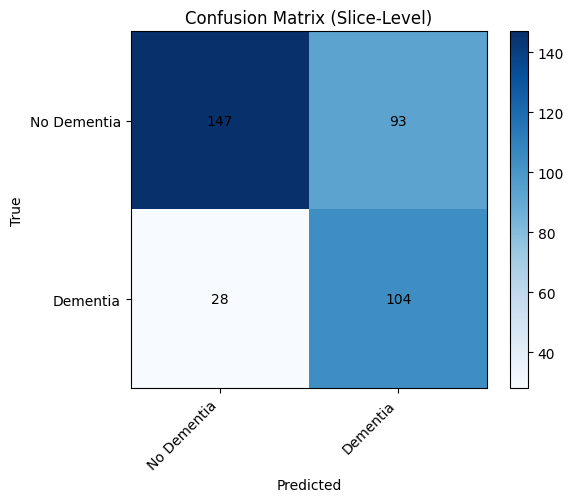

In [ ]:
# === 12. Test evaluation ===
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for imgs, x_tab, labels in test_loader:
        imgs = imgs.to(device)
        x_tab = x_tab.to(device)
        labels = labels.to(device)

        logits = model(imgs, x_tab)
        preds = logits.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(labels.cpu().numpy())

all_preds   = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# Only consider classes actually present in test set for metrics
present_classes = np.unique(all_targets)
present_names   = [CLASS_NAMES[c] for c in present_classes]

print("Classes present in TEST set:", present_classes, "→", present_names)

print("\nSlice-level classification report:")
print(classification_report(
    all_targets,
    all_preds,
    labels=present_classes,
    target_names=present_names,
    digits=4
))

cm = confusion_matrix(all_targets, all_preds, labels=present_classes)
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(len(present_classes)))
ax.set_yticks(range(len(present_classes)))
ax.set_xticklabels(present_names, rotation=45, ha="right")
ax.set_yticklabels(present_names)
plt.colorbar(im, ax=ax)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i,j], ha="center", va="center", color="black")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (Slice-Level)")
plt.tight_layout()
plt.show()


/tmp/ipython-input-1586467571.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_tab_np = row[TAB_COLS].fillna(0.0).astype(np.float32).values
/tmp/ipython-input-1586467571.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_tab_np = row[TAB_COLS].fillna(0.0).astype(np.float32).values
/tmp/ipython-input-1586467571.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('futur

Number of test visits: 31

=== Patient-level (visit-wise) classification report ===
              precision    recall  f1-score   support

 No Dementia     0.8750    0.7000    0.7778        20
    Dementia     0.6000    0.8182    0.6923        11

    accuracy                         0.7419        31
   macro avg     0.7375    0.7591    0.7350        31
weighted avg     0.7774    0.7419    0.7474        31



/tmp/ipython-input-1586467571.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_tab_np = row[TAB_COLS].fillna(0.0).astype(np.float32).values
/tmp/ipython-input-1586467571.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_tab_np = row[TAB_COLS].fillna(0.0).astype(np.float32).values
/tmp/ipython-input-1586467571.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('futur

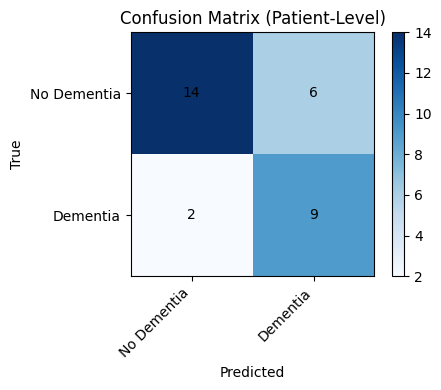

In [ ]:
# === 13. Patient-level (visit-wise) evaluation ===
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix

model.eval()

visit_probs = defaultdict(list)   # visit_id -> list of [num_classes] prob vectors
visit_true  = {}                  # visit_id -> true label (0/1)

with torch.no_grad():
    # loop over *all slices* in df_test directly
    for idx, row in df_test.iterrows():
        vi = row["visit_id"]
        label = int(row["y"])
        img_path = row["png_path"]

        # --- image ---
        img = Image.open(img_path).convert("L")
        x_img = transform_eval(img).unsqueeze(0).to(device)  # [1,1,H,W]

        # --- tabular features (if any) ---
        if TAB_COLS:
            x_tab_np = row[TAB_COLS].fillna(0.0).astype(np.float32).values
            x_tab = torch.from_numpy(x_tab_np).unsqueeze(0).to(device)  # [1,F]
        else:
            x_tab = torch.zeros((1, 0), dtype=torch.float32).to(device)  # dummy

        # --- forward ---
        logits = model(x_img, x_tab)          # [1, num_classes]
        probs  = torch.softmax(logits, dim=1) # [1, num_classes]
        probs_np = probs.cpu().numpy()[0]     # [num_classes]

        visit_probs[vi].append(probs_np)
        visit_true[vi] = label

# aggregate to patient-level
visit_ids = sorted(visit_probs.keys())
y_true_vis = []
y_pred_vis = []

for vi in visit_ids:
    prob_list = visit_probs[vi]               # list of [num_classes]
    mean_probs = np.mean(prob_list, axis=0)   # average across slices
    pred = int(np.argmax(mean_probs))

    y_true_vis.append(visit_true[vi])
    y_pred_vis.append(pred)

y_true_vis = np.array(y_true_vis)
y_pred_vis = np.array(y_pred_vis)

print("Number of test visits:", len(visit_ids))

# Use your binary CLASS_NAMES = ["No Dementia", "Dementia"]
present_classes = np.unique(y_true_vis)
present_names   = [CLASS_NAMES[c] for c in present_classes]

print("\n=== Patient-level (visit-wise) classification report ===")

print(classification_report(
    y_true_vis,
    y_pred_vis,
    labels=present_classes,
    target_names=present_names,
    digits=4
))

cm_vis = confusion_matrix(y_true_vis, y_pred_vis, labels=present_classes)

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm_vis, cmap="Blues")
ax.set_xticks(range(len(present_classes)))
ax.set_yticks(range(len(present_classes)))
ax.set_xticklabels(present_names, rotation=45, ha="right")
ax.set_yticklabels(present_names)
plt.colorbar(im, ax=ax)
for i in range(cm_vis.shape[0]):
    for j in range(cm_vis.shape[1]):
        ax.text(j, i, cm_vis[i,j], ha="center", va="center", color="black")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (Patient-Level)")
plt.tight_layout()
plt.show()


In [ ]:
print(df["visit_id"].nunique())         # total patients
#print(df["visit_id"])                  # individual patient IDs in set
print(df_train["visit_id"].nunique())   # patients in train
#print(df_train["visit_id"])
print(df_val["visit_id"].nunique())     # patients in val
#print(df_val["visit_id"])
print(df_test["visit_id"].nunique())    # patients in test
#print(df_test["visit_id"])

205
156
18
31


# Citation
OpenAI. (2025). ChatGPT (Nov 25 version) [Large language model]

ChatGPT assistance for help with implementing model syntax, evaluation functions, training parameters, and displaying results. All other decisions and running the program were done by user. [Large language model]

Conversations with the user within November 2025

Link to ChatGPT: https://chatgpt.com/